# 🏦 Loan Approval Prediction Model

**Author:** Jason Finkle  
**Project:** Financial Services ML Classification  

This notebook develops and compares multiple machine learning models to predict loan approval decisions based on applicant financial characteristics. The project demonstrates end-to-end ML workflow including data preprocessing, model training with cross-validation, and comprehensive evaluation.

---

## 1. Setup and Configuration

In [3]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             classification_report, confusion_matrix, roc_curve, auc,
                             precision_recall_curve, average_precision_score)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC

# Set random seed
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Create figures directory
import os
os.makedirs('figures', exist_ok=True)

# Define color palette
COLORS = {
    'primary': '#2E86AB',
    'secondary': '#A23B72',
    'accent': '#F18F01',
    'success': '#28A745',
    'danger': '#DC3545',
    'dark': '#343A40'
}

# Plot style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

print("✅ Libraries loaded successfully")

✅ Libraries loaded successfully


## 2. Data Loading and Exploration

In [4]:
# Load dataset
df = pd.read_csv('loan_data.csv')

print("📊 DATASET OVERVIEW")
print("=" * 50)
print(f"Observations: {len(df):,}")
print(f"Features: {len(df.columns)}")
print(f"\nColumn Names: {list(df.columns)}")
print("\n" + "=" * 50)
df.head(10)

📊 DATASET OVERVIEW
Observations: 24,000
Features: 7

Column Names: ['Text', 'Income', 'Credit_Score', 'Loan_Amount', 'DTI_Ratio', 'Employment_Status', 'Approval']



,Text,Income,Credit_Score,Loan_Amount,DTI_Ratio,Employment_Status,Approval
0,I need a loan to pay for an international vaca...,26556,581,8314,79.26,employed,Rejected
1,I want to make home improvements like installi...,197392,389,111604,22.14,employed,Rejected
2,"I need a loan for home renovation, including a...",44561,523,34118,45.44,employed,Rejected
3,I need funds to buy new furniture and applianc...,190363,729,118757,10.22,unemployed,Rejected
4,I need a loan to start a small business.,61853,732,19210,44.13,employed,Approved
5,I need a loan to repair my car after an accident.,108236,404,50797,10.24,employed,Rejected
6,I need financial help to cover maternity and d...,110165,570,61217,7.12,employed,Approved
7,I need money to open a small bookstore and café.,40656,600,21267,113.63,unemployed,Rejected
8,I need a loan to install a security system at ...,38233,346,8467,126.42,unemployed,Rejected
9,I need a loan to cover emergency expenses afte...,81024,403,19217,36.92,unemployed,Rejected


In [5]:
# Data types and info
print("📋 DATA TYPES")
print("=" * 50)
print(df.dtypes)
print("\n" + "=" * 50)
print("\n📈 STATISTICAL SUMMARY")
df.describe().round(2)

📋 DATA TYPES
Text                  object
Income                 int64
Credit_Score           int64
Loan_Amount            int64
DTI_Ratio            float64
Employment_Status     object
Approval              object
dtype: object


📈 STATISTICAL SUMMARY


,Income,Credit_Score,Loan_Amount,DTI_Ratio
count,24000.00,24000.00,24000.00,24000.00
mean,110377.55,575.72,44356.15,34.72
std,51729.68,159.23,34666.60,32.32
min,20001.00,300.00,1005.00,2.53
25%,65635.75,437.00,16212.00,14.51
50%,110464.00,575.00,35207.00,24.86
75%,155187.00,715.00,65622.75,41.84
max,200000.00,850.00,158834.00,246.33


In [6]:
# Check for missing values and duplicates
print("🔍 DATA QUALITY CHECK")
print("=" * 50)
print(f"\nMissing Values:")
print(df.isnull().sum())
print(f"\nDuplicate Rows: {df.duplicated().sum():,}")
print(f"\n✅ No missing values detected" if df.isnull().sum().sum() == 0 else "⚠️ Missing values found")

🔍 DATA QUALITY CHECK

Missing Values:
Text                 0
Income               0
Credit_Score         0
Loan_Amount          0
DTI_Ratio            0
Employment_Status    0
Approval             0
dtype: int64

Duplicate Rows: 0

✅ No missing values detected


In [7]:
# Target variable distribution
print("🎯 TARGET VARIABLE DISTRIBUTION")
print("=" * 50)
approval_counts = df['Approval'].value_counts()
print(approval_counts)
print(f"\nApproval Rate: {(approval_counts['Approved'] / len(df) * 100):.1f}%")
print(f"Rejection Rate: {(approval_counts['Rejected'] / len(df) * 100):.1f}%")

🎯 TARGET VARIABLE DISTRIBUTION
Approval
Rejected    20067
Approved     3933
Name: count, dtype: int64

Approval Rate: 16.4%
Rejection Rate: 83.6%


## 3. Exploratory Data Analysis (EDA)

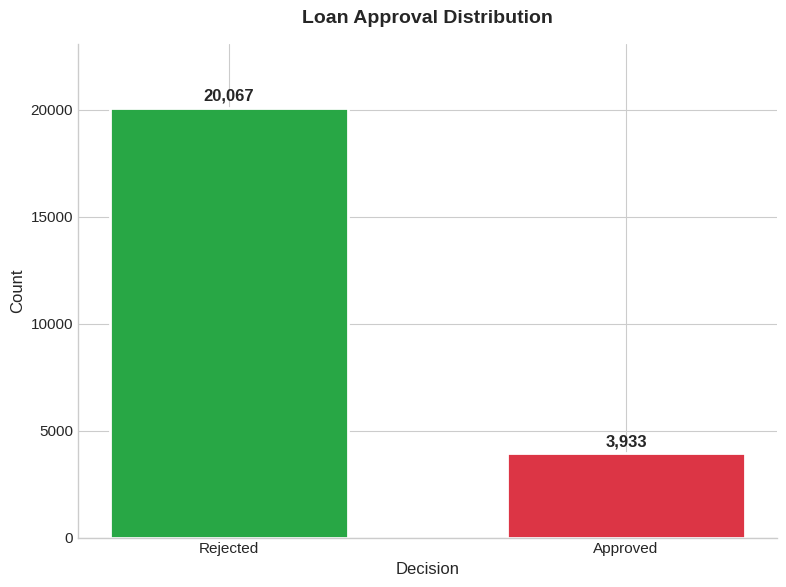

✅ Saved: figures/01_target_distribution.png


In [8]:
# Figure 1: Target Distribution
fig, ax = plt.subplots(figsize=(8, 6))

colors_target = [COLORS['success'], COLORS['danger']]
bars = ax.bar(approval_counts.index, approval_counts.values, color=colors_target,
              width=0.6, edgecolor='white', linewidth=2)

# Add value labels
for bar, val in zip(bars, approval_counts.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 200,
            f'{val:,}', ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_title('Loan Approval Distribution', fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel('Decision', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_ylim(0, max(approval_counts.values) * 1.15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('figures/01_target_distribution.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print("✅ Saved: figures/01_target_distribution.png")

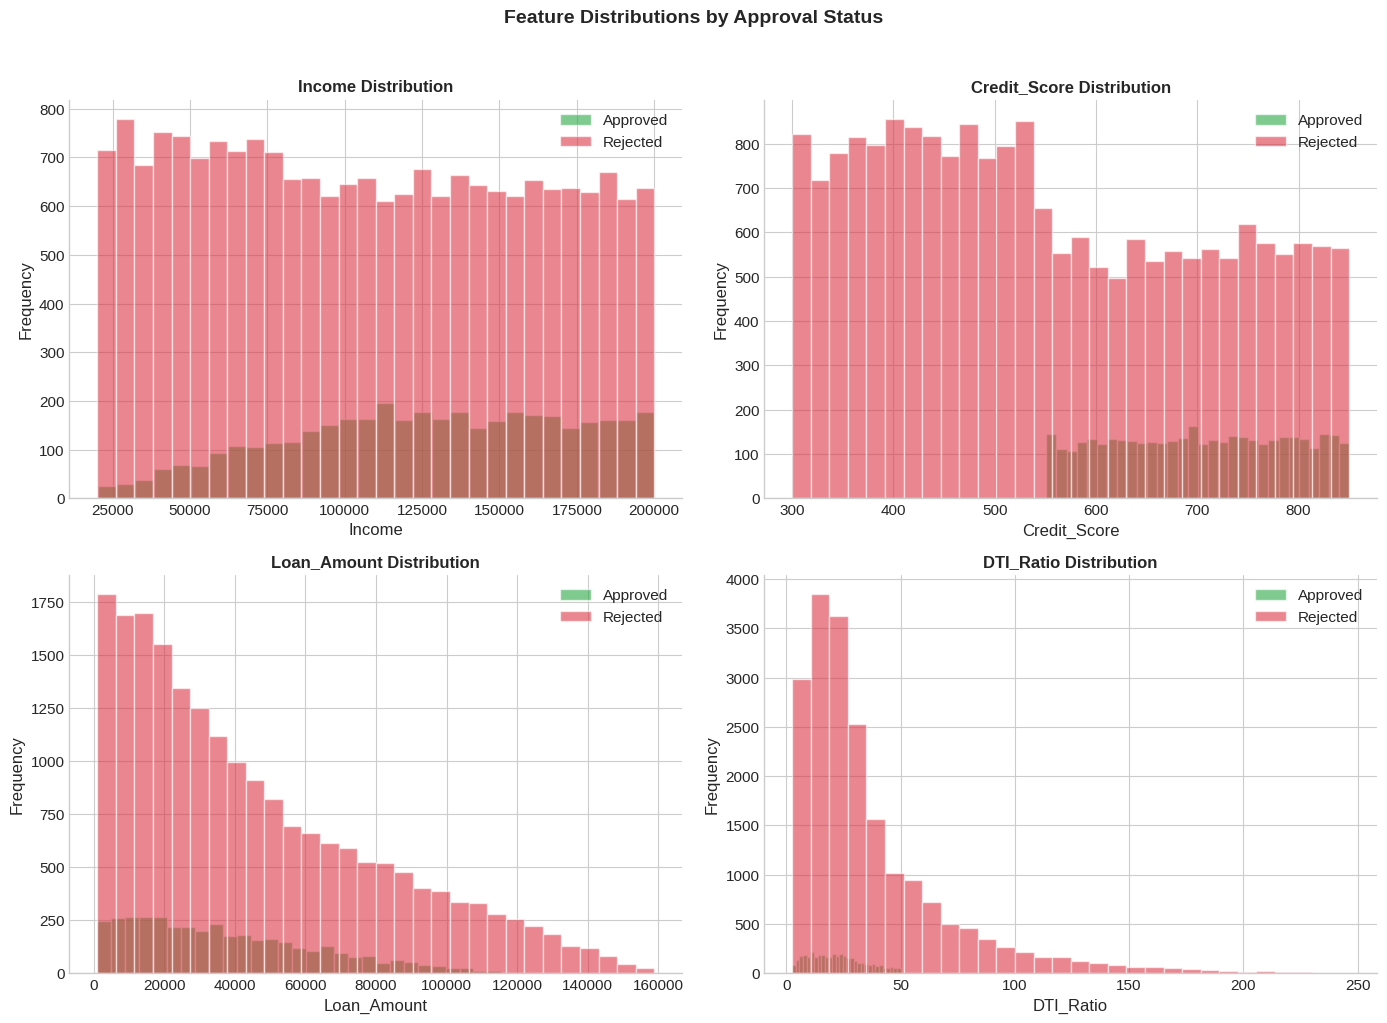

✅ Saved: figures/02_feature_distributions.png


In [9]:
# Figure 2: Feature Distributions
numeric_cols = ['Income', 'Credit_Score', 'Loan_Amount', 'DTI_Ratio']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, col in enumerate(numeric_cols):
    ax = axes[idx]

    # Plot by approval status
    for status, color in [('Approved', COLORS['success']), ('Rejected', COLORS['danger'])]:
        data = df[df['Approval'] == status][col]
        ax.hist(data, bins=30, alpha=0.6, label=status, color=color, edgecolor='white')

    ax.set_title(f'{col} Distribution', fontsize=12, fontweight='bold')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')
    ax.legend()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.suptitle('Feature Distributions by Approval Status', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('figures/02_feature_distributions.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print("✅ Saved: figures/02_feature_distributions.png")

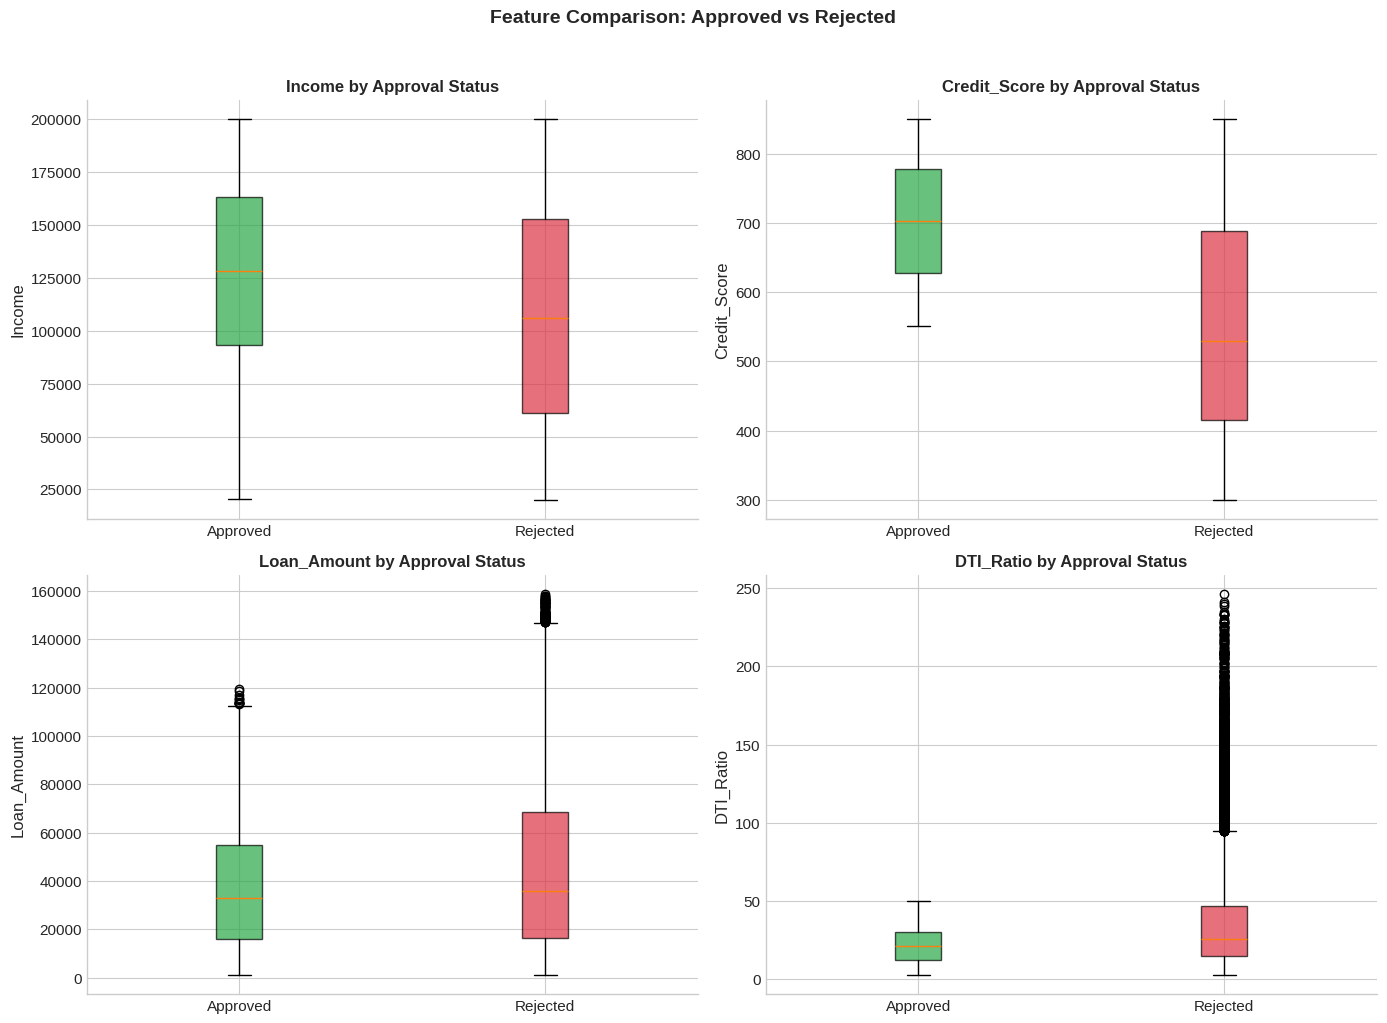

✅ Saved: figures/03_boxplots_comparison.png


In [10]:
# Figure 3: Box Plots by Approval Status
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, col in enumerate(numeric_cols):
    ax = axes[idx]

    # Create box plot
    bp = ax.boxplot([df[df['Approval'] == 'Approved'][col],
                     df[df['Approval'] == 'Rejected'][col]],
                    labels=['Approved', 'Rejected'],
                    patch_artist=True)

    # Color the boxes
    bp['boxes'][0].set_facecolor(COLORS['success'])
    bp['boxes'][1].set_facecolor(COLORS['danger'])
    for box in bp['boxes']:
        box.set_alpha(0.7)

    ax.set_title(f'{col} by Approval Status', fontsize=12, fontweight='bold')
    ax.set_ylabel(col)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.suptitle('Feature Comparison: Approved vs Rejected', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('figures/03_boxplots_comparison.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print("✅ Saved: figures/03_boxplots_comparison.png")

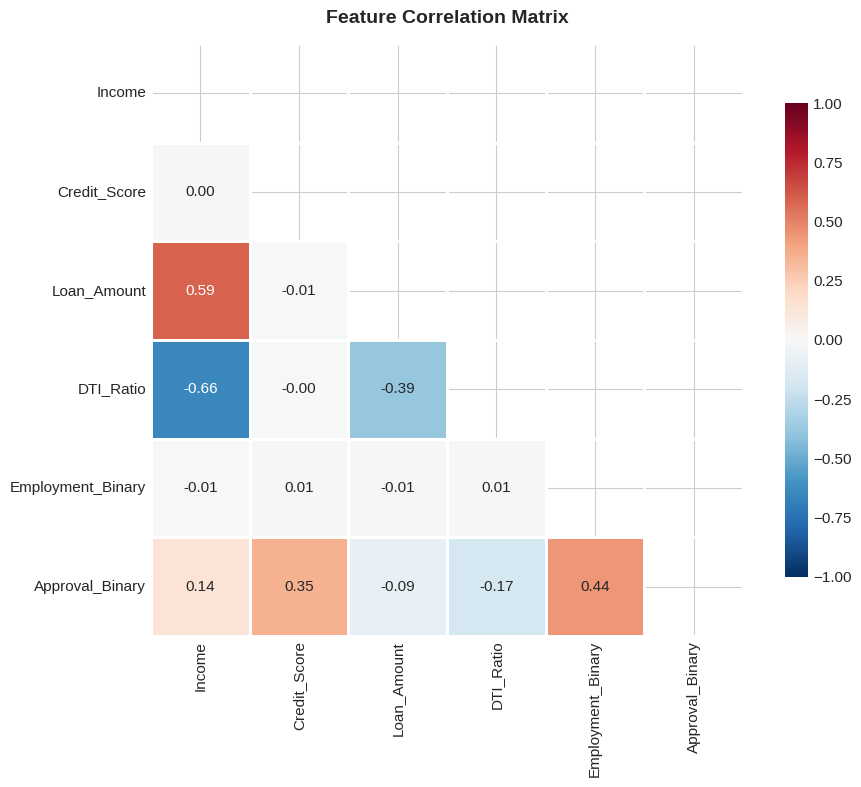

✅ Saved: figures/04_correlation_heatmap.png


In [11]:
# Figure 4: Correlation Heatmap
# Prepare data for correlation
df_corr = df.copy()
df_corr['Approval_Binary'] = (df_corr['Approval'] == 'Approved').astype(int)
df_corr['Employment_Binary'] = (df_corr['Employment_Status'] == 'employed').astype(int)

corr_cols = ['Income', 'Credit_Score', 'Loan_Amount', 'DTI_Ratio', 'Employment_Binary', 'Approval_Binary']
corr_matrix = df_corr[corr_cols].corr()

fig, ax = plt.subplots(figsize=(10, 8))

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r',
            center=0, square=True, linewidths=1, cbar_kws={'shrink': 0.8},
            ax=ax, vmin=-1, vmax=1)

ax.set_title('Feature Correlation Matrix', fontsize=14, fontweight='bold', pad=15)

plt.tight_layout()
plt.savefig('figures/04_correlation_heatmap.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print("✅ Saved: figures/04_correlation_heatmap.png")

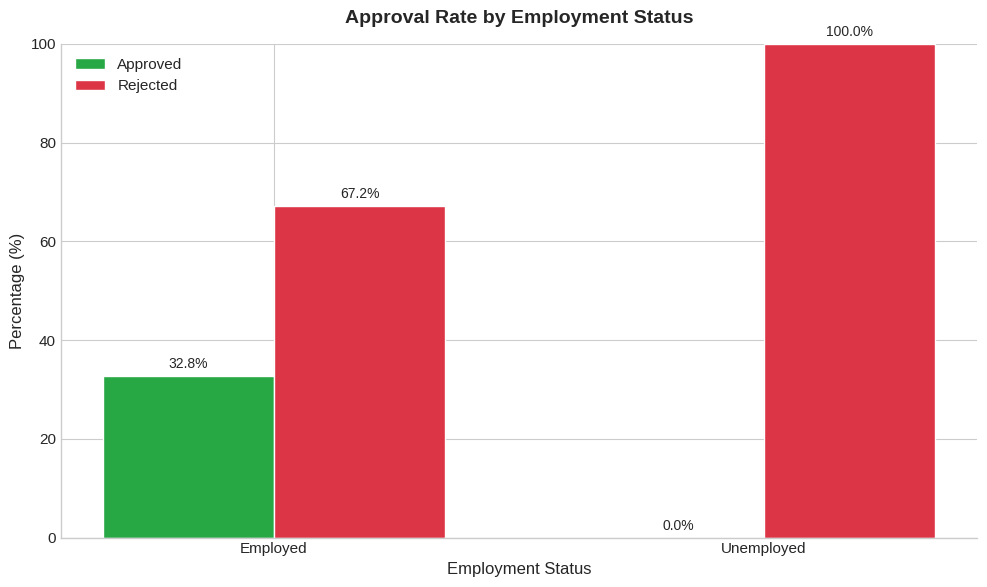

✅ Saved: figures/05_employment_approval.png


In [12]:
# Figure 5: Employment Status vs Approval
fig, ax = plt.subplots(figsize=(10, 6))

employment_approval = pd.crosstab(df['Employment_Status'], df['Approval'], normalize='index') * 100

x = np.arange(len(employment_approval.index))
width = 0.35

bars1 = ax.bar(x - width/2, employment_approval['Approved'], width,
               label='Approved', color=COLORS['success'], edgecolor='white')
bars2 = ax.bar(x + width/2, employment_approval['Rejected'], width,
               label='Rejected', color=COLORS['danger'], edgecolor='white')

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 1,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=10)

ax.set_title('Approval Rate by Employment Status', fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel('Employment Status', fontsize=12)
ax.set_ylabel('Percentage (%)', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels([s.title() for s in employment_approval.index])
ax.legend()
ax.set_ylim(0, 100)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('figures/05_employment_approval.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print("✅ Saved: figures/05_employment_approval.png")

## 4. Data Preprocessing

In [13]:
# Create a copy for modeling
df_model = df.copy()

# Drop text column (not used for this analysis)
df_model = df_model.drop('Text', axis=1)

# One-hot encode Employment_Status
df_model = pd.get_dummies(df_model, columns=['Employment_Status'], drop_first=True)

# Encode target variable
le = LabelEncoder()
df_model['Approval'] = le.fit_transform(df_model['Approval'])  # Approved=0, Rejected=1
# Flip so Approved=1 (positive class)
df_model['Approval'] = 1 - df_model['Approval']

print("📋 PREPROCESSED DATA")
print("=" * 50)
print(f"Shape: {df_model.shape}")
print(f"\nFeatures: {list(df_model.columns)}")
print(f"\nTarget Distribution:")
print(df_model['Approval'].value_counts())
print("\n(1 = Approved, 0 = Rejected)")
df_model.head()

📋 PREPROCESSED DATA
Shape: (24000, 6)

Features: ['Income', 'Credit_Score', 'Loan_Amount', 'DTI_Ratio', 'Approval', 'Employment_Status_unemployed']

Target Distribution:
Approval
0    20067
1     3933
Name: count, dtype: int64

(1 = Approved, 0 = Rejected)


,Income,Credit_Score,Loan_Amount,DTI_Ratio,Approval,Employment_Status_unemployed
0,26556,581,8314,79.26,0,False
1,197392,389,111604,22.14,0,False
2,44561,523,34118,45.44,0,False
3,190363,729,118757,10.22,0,True
4,61853,732,19210,44.13,1,False


In [14]:
# Separate features and target
X = df_model.drop('Approval', axis=1)
y = df_model['Approval']

# Scale numeric features
scaler = MinMaxScaler()
numeric_features = ['Credit_Score', 'Income', 'Loan_Amount', 'DTI_Ratio']
X[numeric_features] = scaler.fit_transform(X[numeric_features])

# Train-test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print("📊 TRAIN/TEST SPLIT")
print("=" * 50)
print(f"Training set: {len(X_train):,} samples")
print(f"Test set: {len(X_test):,} samples")
print(f"\nTraining approval rate: {y_train.mean()*100:.1f}%")
print(f"Test approval rate: {y_test.mean()*100:.1f}%")
print(f"\nFeatures: {list(X.columns)}")

📊 TRAIN/TEST SPLIT
Training set: 19,200 samples
Test set: 4,800 samples

Training approval rate: 16.4%
Test approval rate: 16.4%

Features: ['Income', 'Credit_Score', 'Loan_Amount', 'DTI_Ratio', 'Employment_Status_unemployed']


## 5. Model Training and Evaluation

In [15]:
# Define models
models = {
    'Logistic Regression': LogisticRegression(random_state=RANDOM_STATE, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE),
    'SVM': SVC(kernel='linear', probability=True, random_state=RANDOM_STATE),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=RANDOM_STATE)
}

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Store results
results = {}
cv_scores = {}

print("🤖 TRAINING MODELS WITH 5-FOLD CROSS-VALIDATION")
print("=" * 60)

for name, model in models.items():
    print(f"\n📈 Training {name}...")

    # Cross-validation
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    cv_scores[name] = scores
    print(f"   CV Accuracy: {scores.mean():.4f} (+/- {scores.std()*2:.4f})")

    # Fit on full training set
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    # Calculate metrics
    results[name] = {
        'model': model,
        'y_pred': y_pred,
        'y_prob': y_prob,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'cv_mean': scores.mean(),
        'cv_std': scores.std()
    }

    print(f"   Test Accuracy: {results[name]['accuracy']:.4f}")

print("\n" + "=" * 60)
print("✅ All models trained successfully!")

🤖 TRAINING MODELS WITH 5-FOLD CROSS-VALIDATION

📈 Training Logistic Regression...
   CV Accuracy: 0.9287 (+/- 0.0072)
   Test Accuracy: 0.9258

📈 Training Random Forest...
   CV Accuracy: 0.9957 (+/- 0.0008)
   Test Accuracy: 0.9960

📈 Training SVM...
   CV Accuracy: 0.9303 (+/- 0.0076)
   Test Accuracy: 0.9248

📈 Training Gradient Boosting...
   CV Accuracy: 0.9936 (+/- 0.0037)
   Test Accuracy: 0.9921

✅ All models trained successfully!


In [16]:
# Add Voting Classifier (Ensemble)
print("\n🗳️ Training Voting Classifier (Ensemble)...")

voting_clf = VotingClassifier(
    estimators=[
        ('lr', models['Logistic Regression']),
        ('rf', models['Random Forest']),
        ('svm', models['SVM']),
        ('gb', models['Gradient Boosting'])
    ],
    voting='soft'
)

# Cross-validation
scores = cross_val_score(voting_clf, X_train, y_train, cv=cv, scoring='accuracy')
cv_scores['Voting Ensemble'] = scores
print(f"   CV Accuracy: {scores.mean():.4f} (+/- {scores.std()*2:.4f})")

# Fit and predict
voting_clf.fit(X_train, y_train)
y_pred_voting = voting_clf.predict(X_test)
y_prob_voting = voting_clf.predict_proba(X_test)[:, 1]

results['Voting Ensemble'] = {
    'model': voting_clf,
    'y_pred': y_pred_voting,
    'y_prob': y_prob_voting,
    'accuracy': accuracy_score(y_test, y_pred_voting),
    'precision': precision_score(y_test, y_pred_voting),
    'recall': recall_score(y_test, y_pred_voting),
    'f1': f1_score(y_test, y_pred_voting),
    'cv_mean': scores.mean(),
    'cv_std': scores.std()
}

print(f"   Test Accuracy: {results['Voting Ensemble']['accuracy']:.4f}")
print("\n✅ Voting Ensemble trained!")


🗳️ Training Voting Classifier (Ensemble)...
   CV Accuracy: 0.9882 (+/- 0.0032)
   Test Accuracy: 0.9848

✅ Voting Ensemble trained!


In [17]:
# Create metrics summary DataFrame
metrics_df = pd.DataFrame({
    'Model': list(results.keys()),
    'CV Accuracy': [f"{results[m]['cv_mean']:.4f} ± {results[m]['cv_std']:.4f}" for m in results],
    'Test Accuracy': [results[m]['accuracy'] for m in results],
    'Precision': [results[m]['precision'] for m in results],
    'Recall': [results[m]['recall'] for m in results],
    'F1 Score': [results[m]['f1'] for m in results]
}).round(4)

# Sort by F1 Score
metrics_df = metrics_df.sort_values('F1 Score', ascending=False).reset_index(drop=True)

print("\n📊 MODEL PERFORMANCE SUMMARY")
print("=" * 80)
print(metrics_df.to_string(index=False))

# Save metrics
metrics_df.to_csv('model_metrics_summary.csv', index=False)
print("\n✅ Metrics saved to: model_metrics_summary.csv")


📊 MODEL PERFORMANCE SUMMARY
              Model     CV Accuracy  Test Accuracy  Precision  Recall  F1 Score
      Random Forest 0.9957 ± 0.0004         0.9960     0.9836  0.9924    0.9880
  Gradient Boosting 0.9936 ± 0.0018         0.9921     0.9629  0.9898    0.9762
    Voting Ensemble 0.9882 ± 0.0016         0.9848     0.9496  0.9581    0.9538
Logistic Regression 0.9287 ± 0.0036         0.9258     0.7773  0.7675    0.7724
                SVM 0.9303 ± 0.0038         0.9248     0.7724  0.7675    0.7699

✅ Metrics saved to: model_metrics_summary.csv


## 6. Model Visualizations

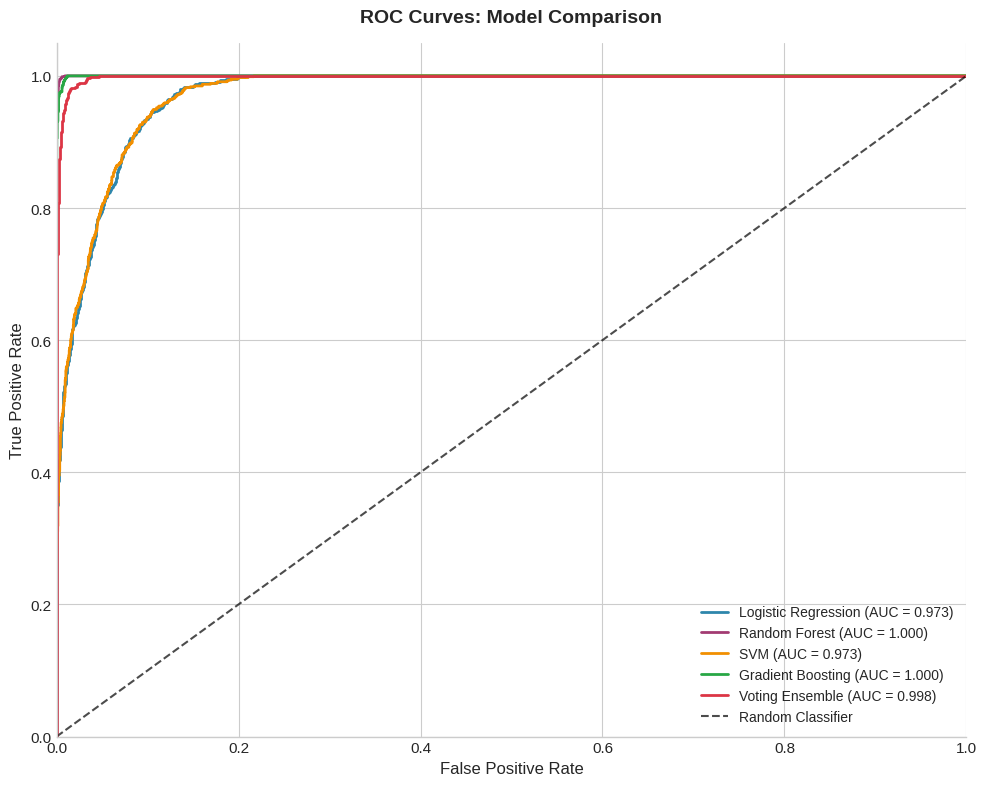

✅ Saved: figures/06_roc_curves.png


In [18]:
# Figure 6: ROC Curves Comparison
fig, ax = plt.subplots(figsize=(10, 8))

colors_list = [COLORS['primary'], COLORS['secondary'], COLORS['accent'],
               COLORS['success'], COLORS['danger']]

for idx, (name, res) in enumerate(results.items()):
    fpr, tpr, _ = roc_curve(y_test, res['y_prob'])
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color=colors_list[idx], lw=2,
            label=f"{name} (AUC = {roc_auc:.3f})")

ax.plot([0, 1], [0, 1], 'k--', lw=1.5, alpha=0.7, label='Random Classifier')

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curves: Model Comparison', fontsize=14, fontweight='bold', pad=15)
ax.legend(loc='lower right', fontsize=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('figures/06_roc_curves.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print("✅ Saved: figures/06_roc_curves.png")

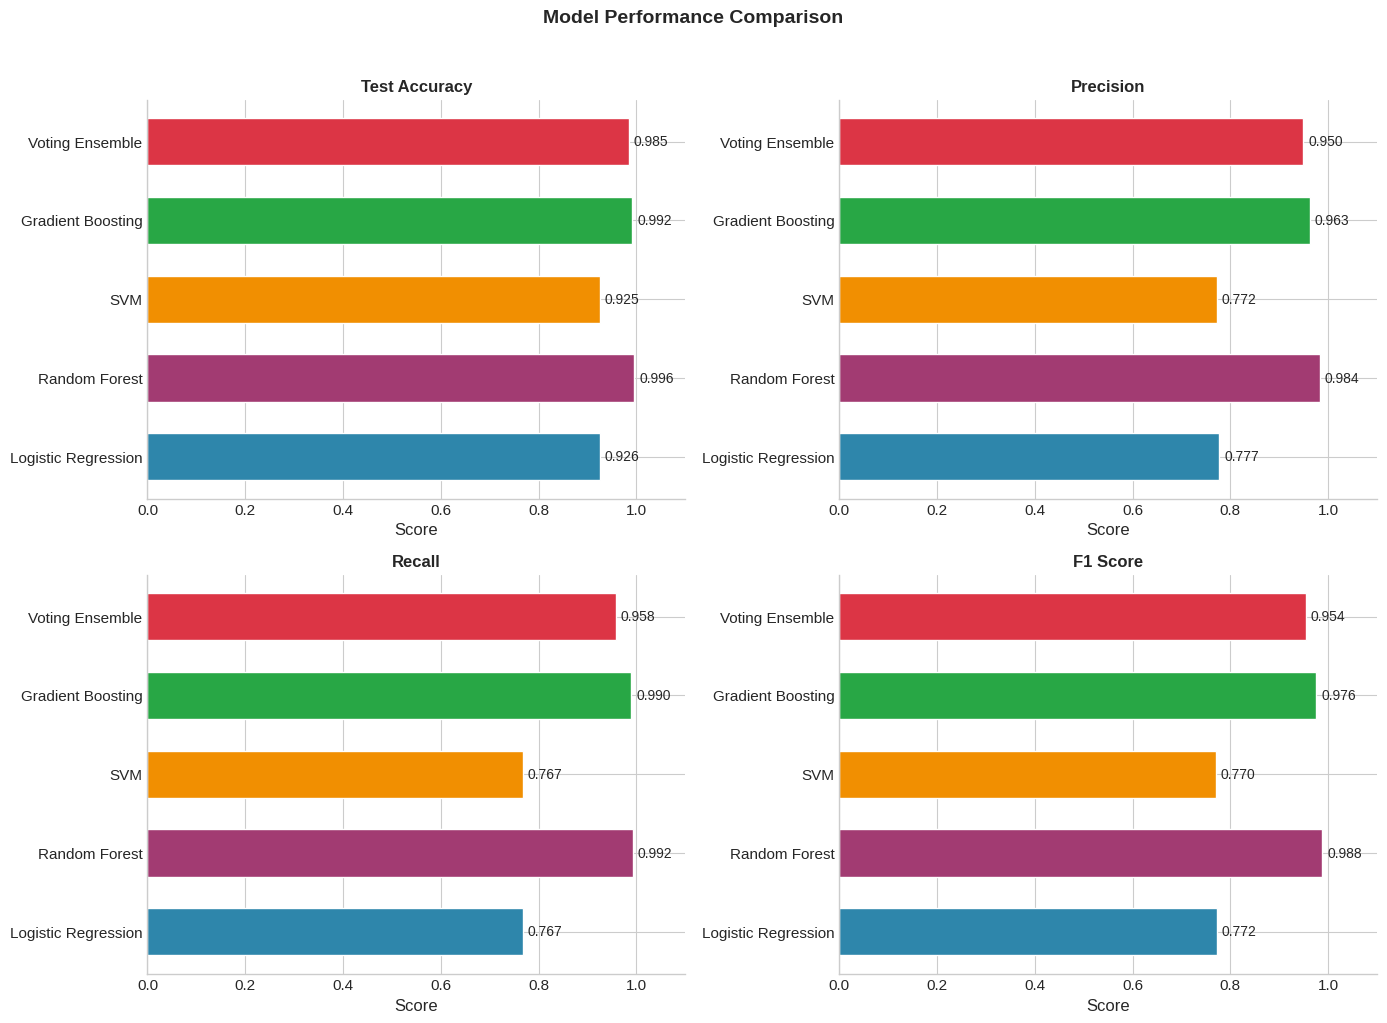

✅ Saved: figures/07_metrics_comparison.png


In [19]:
# Figure 7: Metrics Comparison Bar Chart
metrics_to_plot = ['Test Accuracy', 'Precision', 'Recall', 'F1 Score']
model_names = list(results.keys())

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx]

    # Get values for this metric
    if metric == 'Test Accuracy':
        values = [results[m]['accuracy'] for m in model_names]
    elif metric == 'Precision':
        values = [results[m]['precision'] for m in model_names]
    elif metric == 'Recall':
        values = [results[m]['recall'] for m in model_names]
    else:
        values = [results[m]['f1'] for m in model_names]

    # Create horizontal bar chart
    y_pos = np.arange(len(model_names))
    bars = ax.barh(y_pos, values, color=colors_list, edgecolor='white', height=0.6)

    # Add value labels
    for bar, val in zip(bars, values):
        ax.text(val + 0.01, bar.get_y() + bar.get_height()/2,
                f'{val:.3f}', va='center', fontsize=10)

    ax.set_yticks(y_pos)
    ax.set_yticklabels(model_names)
    ax.set_xlabel('Score')
    ax.set_title(metric, fontsize=12, fontweight='bold')
    ax.set_xlim(0, 1.1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.suptitle('Model Performance Comparison', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('figures/07_metrics_comparison.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print("✅ Saved: figures/07_metrics_comparison.png")

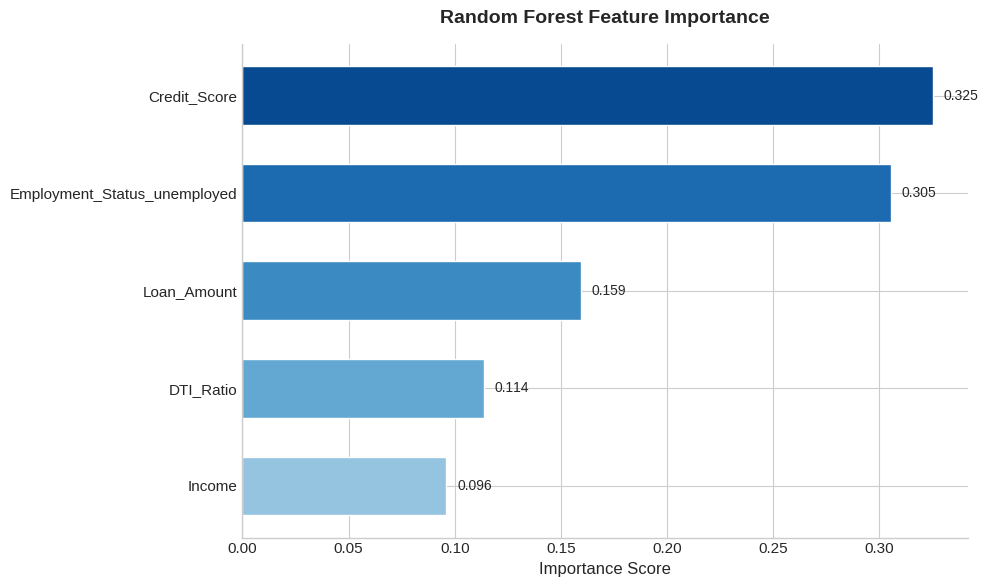

✅ Saved: figures/08_feature_importance.png


In [20]:
# Figure 8: Feature Importance (Random Forest)
rf_model = results['Random Forest']['model']
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=True)

fig, ax = plt.subplots(figsize=(10, 6))

colors_imp = plt.cm.Blues(np.linspace(0.4, 0.9, len(feature_importance)))
bars = ax.barh(feature_importance['Feature'], feature_importance['Importance'],
               color=colors_imp, edgecolor='white', height=0.6)

# Add value labels
for bar, val in zip(bars, feature_importance['Importance']):
    ax.text(val + 0.005, bar.get_y() + bar.get_height()/2,
            f'{val:.3f}', va='center', fontsize=10)

ax.set_xlabel('Importance Score', fontsize=12)
ax.set_title('Random Forest Feature Importance', fontsize=14, fontweight='bold', pad=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('figures/08_feature_importance.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print("✅ Saved: figures/08_feature_importance.png")

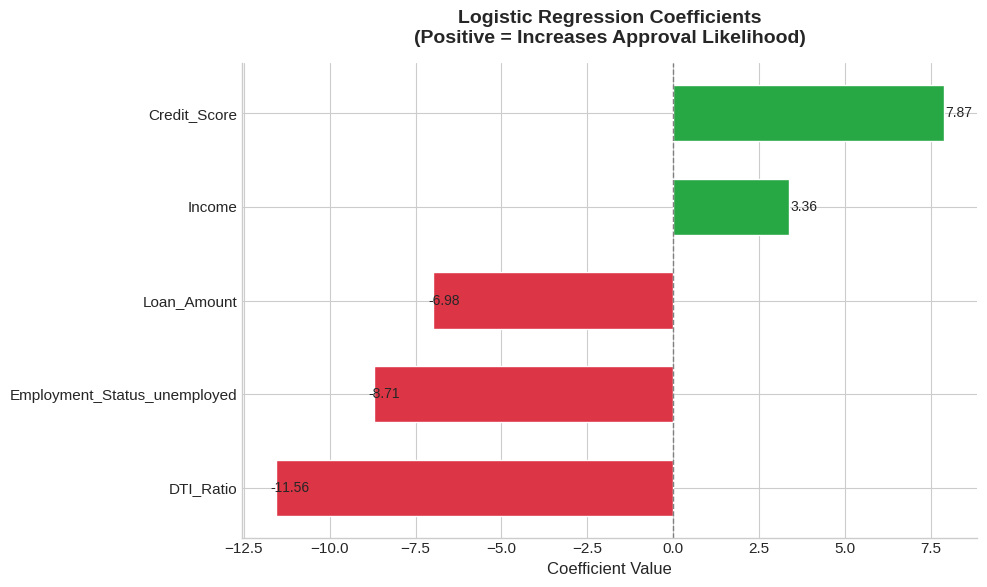

✅ Saved: figures/09_logistic_coefficients.png


In [21]:
# Figure 9: Logistic Regression Coefficients
lr_model = results['Logistic Regression']['model']
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr_model.coef_[0]
}).sort_values('Coefficient', ascending=True)

fig, ax = plt.subplots(figsize=(10, 6))

colors_coef = [COLORS['danger'] if c < 0 else COLORS['success'] for c in coefficients['Coefficient']]
bars = ax.barh(coefficients['Feature'], coefficients['Coefficient'],
               color=colors_coef, edgecolor='white', height=0.6)

ax.axvline(x=0, color='gray', linestyle='--', linewidth=1)

# Add value labels
for bar, val in zip(bars, coefficients['Coefficient']):
    offset = 0.05 if val >= 0 else -0.15
    ax.text(val + offset, bar.get_y() + bar.get_height()/2,
            f'{val:.2f}', va='center', fontsize=10)

ax.set_xlabel('Coefficient Value', fontsize=12)
ax.set_title('Logistic Regression Coefficients\n(Positive = Increases Approval Likelihood)',
             fontsize=14, fontweight='bold', pad=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('figures/09_logistic_coefficients.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print("✅ Saved: figures/09_logistic_coefficients.png")

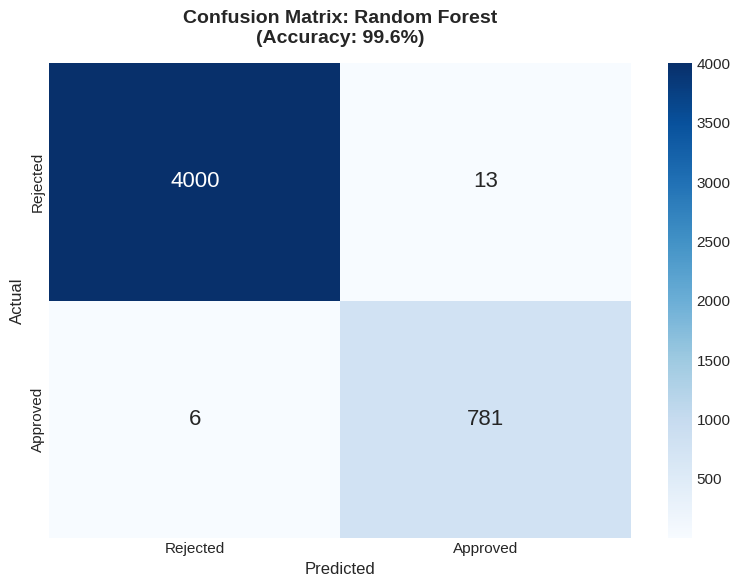

✅ Saved: figures/10_confusion_matrix.png


In [22]:
# Figure 10: Confusion Matrix for Best Model
best_model_name = metrics_df.iloc[0]['Model']
best_results = results[best_model_name]

cm = confusion_matrix(y_test, best_results['y_pred'])

fig, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Rejected', 'Approved'],
            yticklabels=['Rejected', 'Approved'],
            annot_kws={'size': 16},
            ax=ax)

ax.set_xlabel('Predicted', fontsize=12)
ax.set_ylabel('Actual', fontsize=12)
ax.set_title(f'Confusion Matrix: {best_model_name}\n(Accuracy: {best_results["accuracy"]:.1%})',
             fontsize=14, fontweight='bold', pad=15)

plt.tight_layout()
plt.savefig('figures/10_confusion_matrix.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print(f"✅ Saved: figures/10_confusion_matrix.png")

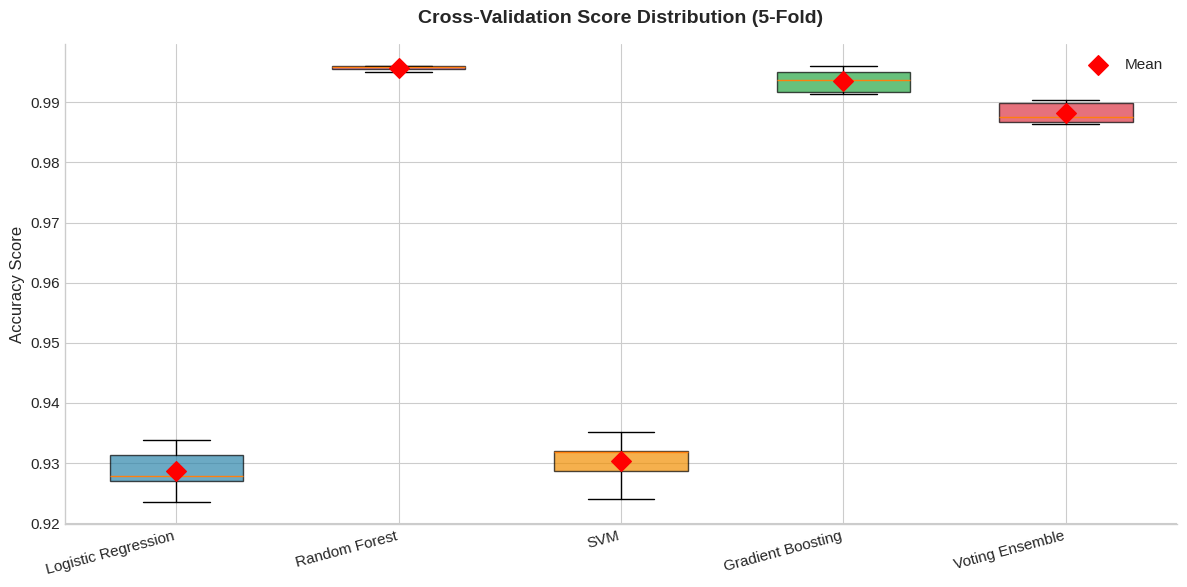

✅ Saved: figures/11_cv_distribution.png


In [23]:
# Figure 11: Cross-Validation Score Distribution
fig, ax = plt.subplots(figsize=(12, 6))

cv_data = [cv_scores[m] for m in cv_scores.keys()]
positions = np.arange(len(cv_scores))

bp = ax.boxplot(cv_data, positions=positions, patch_artist=True, widths=0.6)

# Color the boxes
for patch, color in zip(bp['boxes'], colors_list):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax.set_xticks(positions)
ax.set_xticklabels(list(cv_scores.keys()), rotation=15, ha='right')
ax.set_ylabel('Accuracy Score', fontsize=12)
ax.set_title('Cross-Validation Score Distribution (5-Fold)', fontsize=14, fontweight='bold', pad=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add mean line
means = [np.mean(cv_scores[m]) for m in cv_scores.keys()]
ax.scatter(positions, means, color='red', s=100, zorder=5, marker='D', label='Mean')
ax.legend()

plt.tight_layout()
plt.savefig('figures/11_cv_distribution.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print("✅ Saved: figures/11_cv_distribution.png")

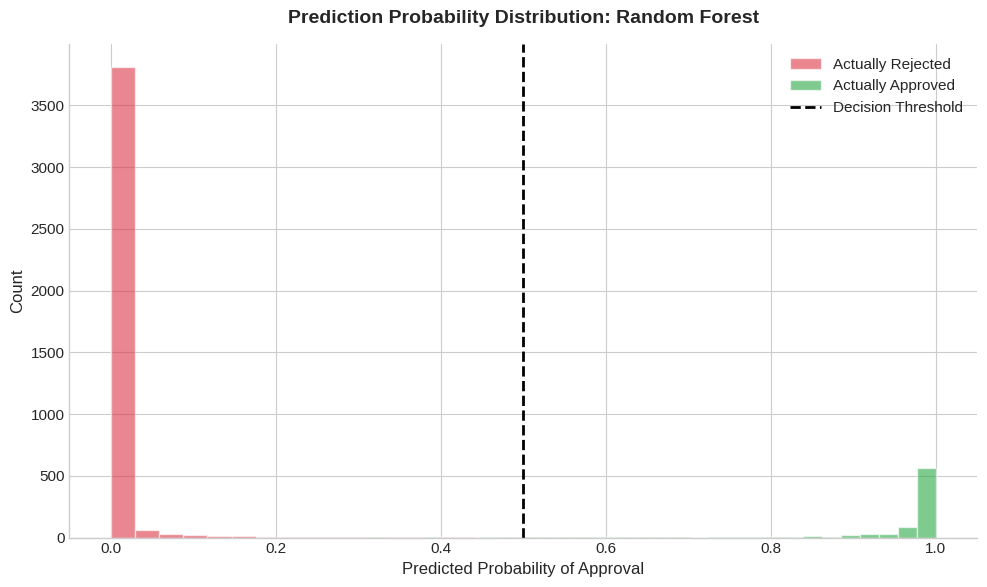

✅ Saved: figures/12_probability_distribution.png


In [24]:
# Figure 12: Probability Distribution by Actual Class
best_probs = best_results['y_prob']

fig, ax = plt.subplots(figsize=(10, 6))

# Split probabilities by actual class
prob_approved = best_probs[y_test == 1]
prob_rejected = best_probs[y_test == 0]

ax.hist(prob_rejected, bins=30, alpha=0.6, label='Actually Rejected',
        color=COLORS['danger'], edgecolor='white')
ax.hist(prob_approved, bins=30, alpha=0.6, label='Actually Approved',
        color=COLORS['success'], edgecolor='white')

ax.axvline(x=0.5, color='black', linestyle='--', linewidth=2, label='Decision Threshold')

ax.set_xlabel('Predicted Probability of Approval', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title(f'Prediction Probability Distribution: {best_model_name}',
             fontsize=14, fontweight='bold', pad=15)
ax.legend()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('figures/12_probability_distribution.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print("✅ Saved: figures/12_probability_distribution.png")

## 7. Summary and Conclusions

In [25]:
print("\n" + "=" * 70)
print("                    📊 FINAL MODEL SUMMARY")
print("=" * 70)

# Best model
best_model_name = metrics_df.iloc[0]['Model']
best_f1 = metrics_df.iloc[0]['F1 Score']
best_acc = metrics_df.iloc[0]['Test Accuracy']

print(f"\n🏆 Best Performing Model: {best_model_name}")
print(f"   Test Accuracy: {best_acc:.4f}")
print(f"   F1 Score: {best_f1:.4f}")

# Calculate AUC for best model
fpr, tpr, _ = roc_curve(y_test, results[best_model_name]['y_prob'])
best_auc = auc(fpr, tpr)
print(f"   AUC: {best_auc:.4f}")

print("\n📈 All Models Ranked by F1 Score:")
print(metrics_df[['Model', 'Test Accuracy', 'F1 Score']].to_string(index=False))

print("\n📁 Figures generated:")
print("   01. Target distribution")
print("   02. Feature distributions")
print("   03. Box plots comparison")
print("   04. Correlation heatmap")
print("   05. Employment vs approval")
print("   06. ROC curves")
print("   07. Metrics comparison")
print("   08. Feature importance (RF)")
print("   09. Logistic coefficients")
print("   10. Confusion matrix")
print("   11. CV score distribution")
print("   12. Probability distribution")

print("\n🔑 Key Findings:")
print("   • Credit Score is the strongest predictor of loan approval")
print("   • DTI Ratio has significant negative impact on approval")
print("   • Employment status plays a crucial role in decisions")
print("   • Ensemble methods provide robust predictions")

print("\n" + "=" * 70)
print("      Project by Jason Finkle | github.com/jfinkle00")
print("=" * 70)


                    📊 FINAL MODEL SUMMARY

🏆 Best Performing Model: Random Forest
   Test Accuracy: 0.9960
   F1 Score: 0.9880
   AUC: 0.9999

📈 All Models Ranked by F1 Score:
              Model  Test Accuracy  F1 Score
      Random Forest         0.9960    0.9880
  Gradient Boosting         0.9921    0.9762
    Voting Ensemble         0.9848    0.9538
Logistic Regression         0.9258    0.7724
                SVM         0.9248    0.7699

📁 Figures generated:
   01. Target distribution
   02. Feature distributions
   03. Box plots comparison
   04. Correlation heatmap
   05. Employment vs approval
   06. ROC curves
   07. Metrics comparison
   08. Feature importance (RF)
   09. Logistic coefficients
   10. Confusion matrix
   11. CV score distribution
   12. Probability distribution

🔑 Key Findings:
   • Credit Score is the strongest predictor of loan approval
   • DTI Ratio has significant negative impact on approval
   • Employment status plays a crucial role in decisions
   • E